In [267]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
#import remap



In [268]:
df = pd.read_csv("../data/Ana_Health-Tabela_Modelo_Previsao_Churn.csv",skiprows=1)

# Criando dataframe com os dados com ocorrência única de won ou lost

In [269]:
colunas = ['id_person','state', 'city', 'postal_code', 'id_person_recommendation', 'Recebe Comunicados?', 'Interesses', 'Pontos de Atenção',
           'id_stage', 'id_org', 'status.1', 'activities_count', 'Qde Todos Atendimentos', 'Faltas Todos Atendimento', 'Datas Atendimento Médico',
           'Datas Acolhimento', 'Datas Psicoterapia','Qde Prescrições', 'Datas Prescrição', 'Qde Respostas WHOQOL']

df = df.drop(colunas, axis=1)

### Transformando a coluna de 'status' em apenas o último status

In [270]:
# def lastStatus(x):
#     if pd.isnull(x):
#         return 'none'
#     s = x.split(';')
#     return s[-1].strip()

# df['status'] = df['status'].apply(lastStatus)
def lastStatus(x):
    s = x.split(';')
    return s[-1].strip()

df['status'] = df['status'].dropna().apply(lastStatus)

In [271]:
df['status'].value_counts()

won     586
lost    492
Name: status, dtype: int64


Se o cliente tiver mais de um start of service é considerado o primeiro

In [272]:
def first_date(x):
    if pd.isnull(x):
        return x
    s = x.split(';')
    return s[0].strip()


df['start_of_service'] = df['start_of_service'].apply(first_date)



Se o cliente tiver com status won e lost_reason é para eliminar o lost_reason
Se estiver com status lost é considerado o último lost_reason

In [273]:
def lost_reason_lost(x,y):
    if pd.isnull(x) or pd.isnull(y):
        return None
    
    if x == 'won':
        return None
    
    s = y.split(';')
    return s[-1].strip()

In [274]:
df['lost_reason'] = df.apply(lambda row: lost_reason_lost(row['status'], row['lost_reason']), axis=1)
df['lost_reason'].value_counts()

[Assinatura] Desligamento                                                                   221
[Assinatura] Não quer seguir com a Ana                                                       64
[Assinatura] Empresa cancelou o benefício da Ana                                             55
[Assinatura] Precisou cortar custos                                                          28
[Assinatura] Cancelamento por inadimplência                                                  26
[Assinatura] Está sem tempo para conciliar os atendimentos                                   23
[Assinatura] Cancelamento após saída da psicoterapeuta do time da Ana                        11
[Assinatura] Não estava sentindo evolução na psicoterapia                                     7
[Assinatura] Final do Piloto                                                                  5
[Assinatura] Desengajou após sentir melhora das questões que a levaram para psicoterapia      5
[Assinatura] Recebeu um benefício simila

In [275]:
def devolve_media(x):
    if pd.isnull(x):
        return None
    x = x.replace(',','.')
    s = x.split(';')
    s = [float(i) for i in s]
    return np.mean(s)

In [276]:
colunas_whoqol = ['Físico', 'Psicológico', 'Social', 'Ambiental']
for coluna in colunas_whoqol:
    df[coluna] = df[coluna].apply(devolve_media)

In [277]:
df['Físico'].describe()

count    898.000000
mean       3.645049
std        0.657525
min        1.300000
25%        3.300000
50%        3.700000
75%        4.100000
max        5.000000
Name: Físico, dtype: float64

Transformando datas em datetime

In [278]:
colunas_de_data = ['contract_start_date', 'start_of_service', 'lost_time', 'add_time', 'won_time', 'lost_time.1']
colunas_seg = ['stay_in_pipeline_stages_welcome','stay_in_pipeline_stages_first_meeting', 'stay_in_pipeline_stages_whoqol']

for coluna in colunas_seg:
    df[coluna+'_h'] = df[coluna]/3600

df = df.drop(colunas_seg, axis=1)

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [279]:
df['Problemas Abertos'].head(200)

0                                        NaN
1                                        NaN
2                                        NaN
3                                        NaN
4                                        NaN
                       ...                  
195    infecção por coronavírus A77 (CIAP-2)
196         dor articular do pé L17 (CIAP-2)
197                                      NaN
198                                      NaN
199                                      NaN
Name: Problemas Abertos, Length: 200, dtype: object

In [280]:
def tem_ou_nao(x):
    if pd.isnull(x) :
        return 0
    return 1

df['Problemas Abertos'] = df['Problemas Abertos'].apply(tem_ou_nao)

In [281]:
df['Problemas Abertos'].describe()


count    1201.000000
mean        0.507910
std         0.500146
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Problemas Abertos, dtype: float64

### Criando o dataframe com apenas as linhas que tem valor de status igual a won ou lost.

In [282]:
df_simple = df[df['status'].isin(['won', 'lost'])]

### Aplicando os filtros de status igual a won e data de fim de contrato igual a NaN. Além do filtro de status igual a lost e com data de fim de contrato 

In [283]:
f1 = df_simple[(df_simple['status'] == 'won') & (df_simple['contract_end_date'].isna())] 
f2 = df_simple[(df_simple['status'] == 'lost') & (df_simple['contract_end_date'].notna())] 

df_simple = pd.concat([f1, f2])

<AxesSubplot:xlabel='contract_end_date'>

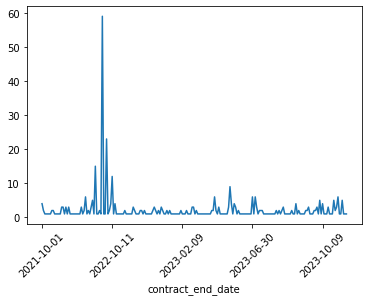

In [284]:
df_simple.groupby('contract_end_date')['status'].count().sort_index().rolling(1).sum().plot(rot=45)

### Mudando a coluna de data de começo de contrato para formato de data do pandas

In [285]:
df_simple['contract_start_date'] = pd.to_datetime(df_simple['contract_start_date'])
df_simple = df_simple.sort_values(by=['contract_start_date'])

In [286]:
df_simple['status'].value_counts()

won     574
lost    471
Name: status, dtype: int64

In [287]:
# #Dado um intervalo de tempo, criar analises de churn baseado na saúde da empresa
# #Criar um modelo de previsão de churn
# # saintes, entrantes, médias de pagamentos, std.pagamentos. Qde Total de Tentativas de Cobrança, Qde Total de Faturas

# df_filtered = df_simple[df_simple['contract_start_date'].between('2021-01-01', '2021-12-31')]
# df_filtered

# #novo dataframe com as colunas que serão usadas no modelo

# new_df = pd.DataFrame(columns=['saintes', 'entrantes', 'media_pagamentos', 'std_pagamentos', 'qde_total_tentativas_cobranca', 'qde_total_faturas', 'churn'])

# #atribuir valores ao novo dataframe

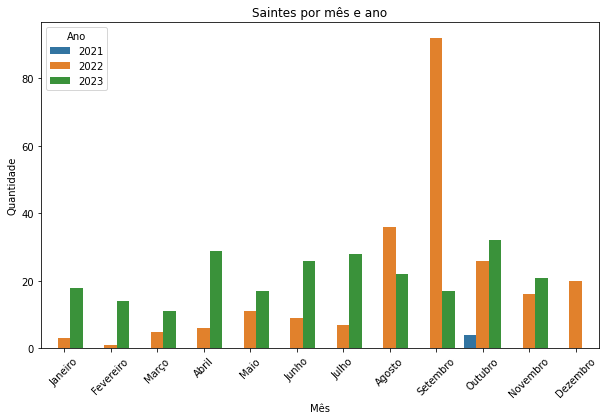

In [288]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Make sure to import pandas if not already done

# Assuming df_simple is your DataFrame

# Convert 'contract_end_date' to datetime if not already in that format
df_simple['contract_end_date'] = pd.to_datetime(df_simple['contract_end_date'])

nome_dos_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

coluna = 'contract_end_date'
new_name = coluna + '_year'
df_simple[new_name] = df_simple[coluna].dt.year

# Plotar gráfico de barras separado por ano
plt.figure(figsize=(10, 6))  # Definir tamanho da figura
# Usar seaborn para criar facetas
sns.countplot(x=df_simple[coluna].dt.month, hue=df_simple[new_name])
plt.title('Saintes por mês e ano')  # <- Fix the line ending
# Rotacionar labels do eixo x
plt.xticks(rotation=45)
# Alterar labels do eixo x
plt.xticks(np.arange(12), nome_dos_meses)
# Trocar legenda da coluna
plt.legend(title='Ano', loc='upper left', labels=['2021', '2022', '2023'])
# Trocar nome do eixo x
plt.xlabel('Mês')
# Trocar nome do eixo y
plt.ylabel('Quantidade')
plt.show()


In [289]:
colunas_de_data = ['contract_end_date']

# LEmbrar de colocar a 'contract_end_date' para time delta posteriormente

#Trocar a data pelo tempo em dias ate o dia de hoje
for coluna in colunas_de_data:
    df[coluna] = pd.to_datetime(df[coluna], errors='coerce')
    df[coluna] = df[coluna].apply(lambda x: (datetime.now() - x).days)




In [290]:
def ultima_mensagem(x,y):
    if (y == None):
        return "Cliente"
    
    if x>y:
        return "Cliente"
    
    else:
        return "Empresa"

In [291]:
df_aux = df_simple[df_simple['Data Última Mensagens Inbound'].notnull()]
df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
df_aux['Tempo Última Mensagem Inbound'] = df_aux['Data Última Mensagens Inbound'].apply(lambda x: (datetime.now() - x).days)
df_aux['Tempo Última Mensagem Outbound'] = df_aux['Data Última Mensagens Outbound'].apply(lambda x: (datetime.now() - x).days)

df_aux['Quem Enviou Última Mensagem'] = df_aux.apply(lambda row: ultima_mensagem(row['Tempo Última Mensagem Inbound'], row['Tempo Última Mensagem Outbound']), axis=1)


C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\4269974155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Inbound'] = pd.to_datetime(df_aux['Data Última Mensagens Inbound'])
C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\4269974155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Data Última Mensagens Outbound'] = pd.to_datetime(df_aux['Data Última Mensagens Outbound'])
C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\4269974155.py:4: SettingWithCopyWarnin

In [292]:
df_aux['Quem Enviou Última Mensagem'].value_counts()
df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\3194983688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Status Assinatura'] = df_aux['status'].apply(lambda x: "Ativa" if x == "won" else "Inativa")


<AxesSubplot:title={'center':'Status dos Usuários em Relação a Última Mensagema'}, xlabel='Status Assinatura', ylabel='Quantidade Usuários'>

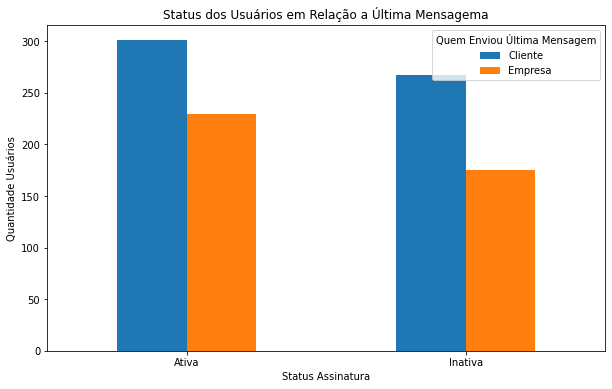

In [293]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade Usuários', title='Status dos Usuários em Relação a Última Mensagema', figsize=(10,6))


<AxesSubplot:title={'center':'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

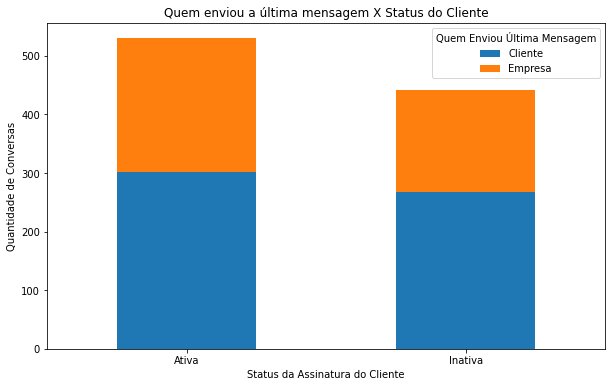

In [294]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', stacked=True, figsize=(10,6))


<AxesSubplot:title={'center':'Quem enviou a última mensagem X Status do Cliente'}, xlabel='Status da Assinatura do Cliente', ylabel='Quantidade de Conversas'>

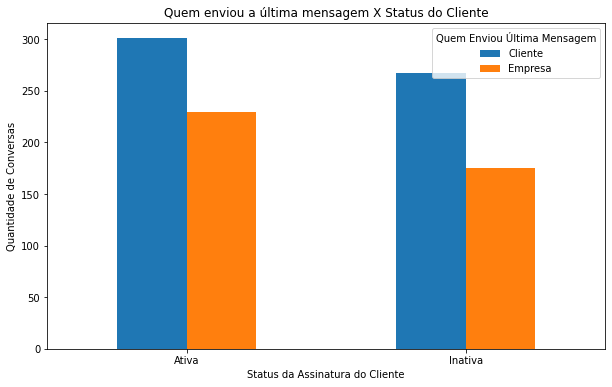

In [295]:
df_aux.groupby('Status Assinatura')['Quem Enviou Última Mensagem'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Quantidade de Conversas', xlabel="Status da Assinatura do Cliente", title='Quem enviou a última mensagem X Status do Cliente', figsize=(10,6))


In [296]:
df_agosto = pd.read_csv('../data/Agosto/Ana Health_Tabela Modelo Previsão Churn - Tabela até 08_23.csv', skiprows=1)
df_julho = pd.read_csv('../data/Julho/Ana Health_Tabela Modelo Previsão Churn - Tabela até 07_23.csv', skiprows=1)
df_junho = pd.read_csv('../data/Junho/Ana Health_Tabela Modelo Previsão Churn - Tabela até 06_23.csv', skiprows=1)
df_novembro = pd.read_csv('../data/Novembro/Ana Health_Tabela Modelo Previsão Churn - Tabela Geral.csv', skiprows=1)
df_outubro = pd.read_csv('../data/Outubro/Ana Health_Tabela Modelo Previsão Churn - Tabela até 10_23.csv', skiprows=1)
df_setembro = pd.read_csv('../data/Setembro/Ana Health_Tabela Modelo Previsão Churn - Tabela até 09_23.csv', skiprows=1)



# colunas_whoqol = ['Físico', 'Psicológico', 'Social', 'Ambiental']
# for coluna in colunas_whoqol:
#     print(df_agosto[coluna].value_counts())


In [297]:
import script_dataframe
import importlib
importlib.reload(script_dataframe)
tratamento = script_dataframe.tratamento

df_agosto = tratamento(df_agosto)
df_julho = tratamento(df_julho)
df_junho = tratamento(df_junho)
df_novembro = tratamento(df_novembro)
df_outubro = tratamento(df_outubro)
df_setembro = tratamento(df_setembro)

In [298]:

def prox_status(df1, df2):
    df2_novo = df2[df2['id_person'].isin(df1['id_person'].values)]
    return pd.merge(df1,df2_novo[['id_person','status']],on='id_person', how='left',suffixes=['','_prox_mes'])

df_junho = prox_status(df_junho, df_julho)
df_julho = prox_status(df_julho, df_agosto)
df_agosto = prox_status(df_agosto, df_setembro)
df_setembro = prox_status(df_setembro, df_outubro)
df_outubro  = prox_status(df_outubro, df_novembro)

In [299]:
# df_junho['status_prox_mes'].value_counts()
# df_julho.dropna()
# df_junho.columns
df_junho['status_prox_mes'].value_counts()
# df_junho.tail(100)

lost    450
won     410
Name: status_prox_mes, dtype: int64

In [300]:
df_julho['status_prox_mes'].value_counts()

lost    455
won     444
Name: status_prox_mes, dtype: int64

In [301]:
df_junho['status_prox_mes'].value_counts()

lost    450
won     410
Name: status_prox_mes, dtype: int64

In [302]:
df_julho['status_prox_mes'].value_counts()

lost    455
won     444
Name: status_prox_mes, dtype: int64

In [303]:
df_agosto['status_prox_mes'].value_counts()

won     476
lost    460
Name: status_prox_mes, dtype: int64

In [304]:
df_setembro['status_prox_mes'].value_counts()

won     499
lost    463
Name: status_prox_mes, dtype: int64

In [305]:
df_outubro['status_prox_mes'].value_counts()

won     559
lost    464
Name: status_prox_mes, dtype: int64

In [306]:
df_teste = df_outubro.copy()

df_teste['Target'] = df_teste['status_prox_mes'] == 'won'
df_teste

,id_person,birthdate,id_gender,id_marrital_status,id_health_plan,contract_start_date,contract_end_date,id_continuity_pf,Canal de Preferência,notes_count,...,Qde Total de Faturas Inadimpletes,Valor Total Inadimplência,Qde Perfis de Pagamento Inativos,Tempo até Sair,Tem Problema em Aberto,Tempo Última Mensagem Inbound,Tempo Última Mensagem Outbound,Quem Enviou Última Mensagem,status_prox_mes,Target
0,483,76.0,64.0,80.0,453.0,2021-01-27,2023-08-26,NaN,NaN,3,...,NaN,NaN,NaN,941.0,0,180.0,71.0,Cliente,lost,False
1,1259,31.0,64.0,82.0,NaN,2021-05-10,2022-09-09,338.0,NaN,1,...,NaN,NaN,NaN,487.0,1,489.0,388.0,Cliente,lost,False
2,975,36.0,63.0,82.0,NaN,2021-06-28,2022-08-16,NaN,NaN,0,...,NaN,NaN,NaN,414.0,1,NaN,493.0,Empresa,lost,False
3,974,36.0,63.0,80.0,NaN,2021-06-28,2022-08-16,NaN,NaN,0,...,NaN,NaN,NaN,414.0,0,581.0,493.0,Cliente,lost,False
4,973,37.0,64.0,80.0,412.0,2021-06-28,2022-02-07,339.0,NaN,1,...,NaN,NaN,NaN,224.0,0,681.0,681.0,Empresa,lost,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,5922,27.0,63.0,82.0,NaN,2023-10-26,NaT,NaN,NaN,2,...,0.0,120.0,NaN,NaN,0,35.0,32.0,Cliente,won,True
1019,5924,31.0,63.0,82.0,NaN,2023-10-30,NaT,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0,30.0,30.0,Empresa,won,True
1020,5925,22.0,64.0,80.0,NaN,2023-10-30,NaT,NaN,239.0,0,...,NaN,NaN,NaN,NaN,0,32.0,32.0,Empresa,won,True
1021,5931,23.0,64.0,82.0,NaN,2023-10-31,NaT,NaN,NaN,0,...,NaN,NaN,NaN,NaN,0,NaN,30.0,Empresa,won,True


In [307]:
corr = df_teste.corr(numeric_only=True)
corr

,id_person,birthdate,id_gender,id_marrital_status,id_health_plan,id_continuity_pf,Canal de Preferência,notes_count,done_activities_count,start_of_service,...,Valor Médio da Mensalidade,Qde Total de Faturas Pagas após Vencimento,Qde Total de Faturas Inadimpletes,Valor Total Inadimplência,Qde Perfis de Pagamento Inativos,Tempo até Sair,Tem Problema em Aberto,Tempo Última Mensagem Inbound,Tempo Última Mensagem Outbound,Target
id_person,1.000000,0.077154,0.034635,0.093865,0.004016,0.167719,-0.167700,0.082847,-0.325319,-0.977527,...,0.122653,-0.248975,-0.150559,-0.107452,NaN,-0.543733,-0.107225,-0.678010,-0.645195,0.600077
birthdate,0.077154,1.000000,-0.039258,0.471906,-0.042821,0.066191,0.007041,0.058014,0.010142,-0.076266,...,-0.004142,-0.013402,-0.079913,-0.077070,NaN,0.021614,0.008301,-0.039612,-0.069288,0.091896
id_gender,0.034635,-0.039258,1.000000,-0.039880,-0.060768,-0.082891,0.274643,0.032363,0.232119,-0.042387,...,-0.068056,-0.014729,-0.021859,-0.025159,NaN,0.048840,0.021244,-0.056143,-0.041758,0.021976
id_marrital_status,0.093865,0.471906,-0.039880,1.000000,0.011882,0.032634,-0.047522,0.048231,0.000980,-0.087899,...,-0.010010,0.099968,-0.011966,-0.003238,NaN,-0.011990,-0.004839,-0.056525,-0.080114,0.079075
id_health_plan,0.004016,-0.042821,-0.060768,0.011882,1.000000,0.023627,-0.111456,0.026103,-0.024041,0.003107,...,0.112701,-0.074128,0.007661,0.004923,NaN,0.105388,0.008478,-0.034304,-0.028795,0.009123
id_continuity_pf,0.167719,0.066191,-0.082891,0.032634,0.023627,1.000000,-0.082775,-0.124081,-0.358531,-0.175278,...,-0.045841,-0.320332,-0.107274,-0.097718,NaN,-0.262249,-0.139613,0.322528,0.292762,-0.485506
Canal de Preferência,-0.167700,0.007041,0.274643,-0.047522,-0.111456,-0.082775,1.000000,0.123753,0.268101,0.148131,...,-0.127379,-0.021279,-0.066728,-0.073024,NaN,0.213627,-0.017064,0.060040,0.125507,-0.108518
notes_count,0.082847,0.058014,0.032363,0.048231,0.026103,-0.124081,0.123753,1.000000,0.273727,-0.117221,...,0.029014,0.127105,-0.094520,-0.095803,NaN,0.076886,0.217444,-0.317327,-0.284505,0.199456
done_activities_count,-0.325319,0.010142,0.232119,0.000980,-0.024041,-0.358531,0.268101,0.273727,1.000000,0.287149,...,-0.030198,0.137290,0.018666,0.006003,NaN,0.450151,0.171888,-0.106601,-0.167608,-0.017719
start_of_service,-0.977527,-0.076266,-0.042387,-0.087899,0.003107,-0.175278,0.148131,-0.117221,0.287149,1.000000,...,-0.103451,0.226206,0.159210,0.116419,NaN,0.526244,0.102557,0.701360,0.667671,-0.575881


<AxesSubplot:>

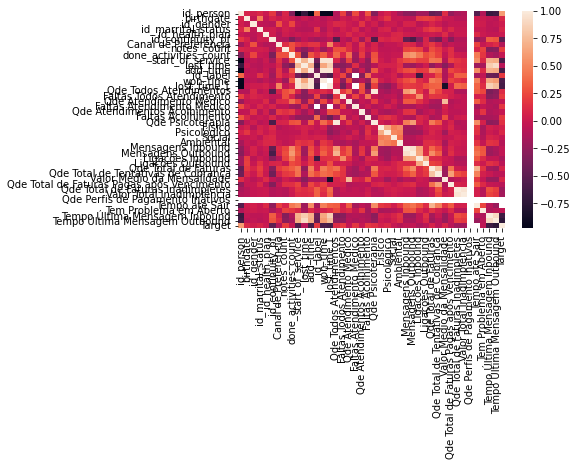

In [308]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [309]:
df_total = pd.concat([df_junho, df_julho, df_agosto, df_setembro, df_outubro])

df_total['Target'] = df_total['status_prox_mes'] == 'won'

df_total['Target'].value_counts()
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4680 entries, 0 to 1022
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   id_person                                   4680 non-null   int64         
 1   birthdate                                   4675 non-null   float64       
 2   id_gender                                   4662 non-null   float64       
 3   id_marrital_status                          4670 non-null   float64       
 4   id_health_plan                              2204 non-null   float64       
 5   contract_start_date                         4680 non-null   datetime64[ns]
 6   contract_end_date                           2292 non-null   datetime64[ns]
 7   id_continuity_pf                            1687 non-null   float64       
 8   Canal de Preferência                        1473 non-null   float64       
 9   notes_co

<AxesSubplot:>

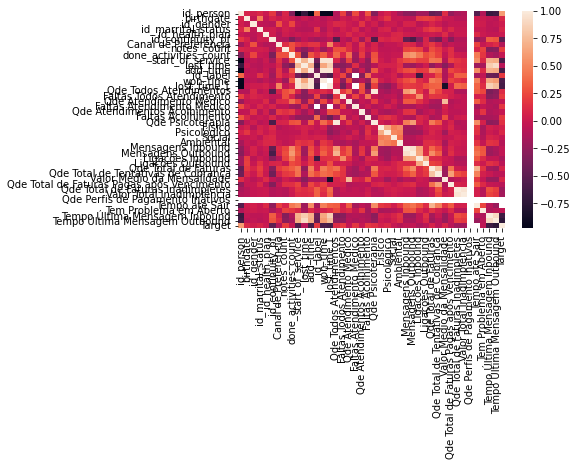

In [310]:
corr = df_teste.corr(numeric_only=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

<AxesSubplot:title={'center':'Planos de Saúde mais comuns'}>

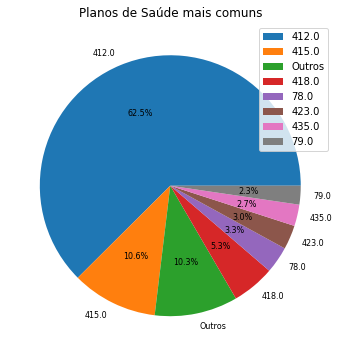

In [311]:


df_plan_mais_comum = df[df['status'] == 'won']
df_plan_mais_comum = df_plan_mais_comum[df_plan_mais_comum['id_health_plan'].notna()]

top_7_values = df_plan_mais_comum['id_health_plan'].value_counts().nlargest(7).index
df_plan_mais_comum['id_health_plan'] = df_plan_mais_comum['id_health_plan'].apply(lambda x: x if x in top_7_values else 'Outros')

df_plan_mais_comum['id_health_plan'].value_counts().plot.pie(legend=True, figsize=(10,6), title='Planos de Saúde mais comuns', ylabel='', autopct='%1.1f%%', fontsize=8)



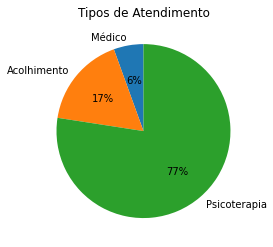

In [312]:
labels = ["Médico", "Acolhimento", "Psicoterapia"]
values = [df["Qde Atendimento Médico"].sum(), df["Qde Atendimentos Acolhimento"].sum(), df["Qde Psicoterapia"].sum()]

plt.pie(values, labels=labels, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 10})
plt.title("Tipos de Atendimento")
plt.show()



In [313]:
def remap_categories(
    series: pd.Series,
    old_categories: tuple[str],
    new_category: str,
) -> pd.Series:
    # Add the new category to the list of valid categories.
    series = series.cat.add_categories(new_category)

    # Set all items of the old categories as the new category.
    remapped_items = series.isin(old_categories)
    series.loc[remapped_items] = new_category

    # Clean up the list of categories, the old categories no longer exist.
    series = series.cat.remove_unused_categories()

    return series

In [314]:
df_total['id_marrital_status'].value_counts()

80.0    3309
82.0    1182
83.0     159
81.0      20
Name: id_marrital_status, dtype: int64

In [315]:
def transform_to_category(x,qtd_itens,lista_itens):
   for i in range(qtd_itens):
      if x == lista_itens[i]:
         return str(x)
   return 'Outros'
   

colunas = df_total.columns
c1 = colunas[:10]
c2 = colunas[10:20]
c3 = colunas[20:30]
c4 = colunas[30:40]
c5 = colunas[40:]

colunas_dropadas = ['id_person','contract_start_date','contract_end_date','id_continuity_pf','Canal de Preferência','status','lost_time','add_time','id_label','won_time','lost_time.1','lost_reason','lost_reason.1',\
                    'Qde Atendimento Médico','Faltas Atendimento Médico',	'Qde Atendimentos Acolhimento',	'Faltas Acolhimento',	'Qde Psicoterapia',	'Faltas Psicoterapia','Data Última Ligações Outbound',\
                     'Data Última Ligações Inbound','Qde Total de Faturas Pagas após Vencimento','Qde Perfis de Pagamento Inativos','Tempo até Sair', 'Valor Médio da Mensalidade', 'status_prox_mes', 'Qde Total de Faturas','Problemas Abertos']


colunas_dropadas_regr = ['id_person','contract_start_date','contract_end_date','id_continuity_pf','Canal de Preferência','status','lost_time','add_time','id_label','won_time','lost_time.1','lost_reason','lost_reason.1',\
                     'Qde Atendimento Médico','Faltas Atendimento Médico',	'Qde Atendimentos Acolhimento',	'Faltas Acolhimento',	'Qde Psicoterapia',	'Faltas Psicoterapia','Data Última Ligações Outbound',\
                     'Data Última Ligações Inbound','Qde Total de Faturas Pagas após Vencimento','Qde Perfis de Pagamento Inativos', 'Valor Médio da Mensalidade', 'status_prox_mes', 'Qde Total de Faturas', 'Target','Problemas Abertos']


colunas_get_dummies = ['id_gender','id_marrital_status','id_health_plan','notes_count','Método de Pagamento','Qde Total de Faturas Inadimpletes', 'Quem Enviou Última Mensagem']

#coluna de genero
df_total['id_gender'] = df_total['id_gender'] = df_total['id_gender'].apply(lambda x: transform_to_category(x,2,[63,64]))
#coluna de estado civil
#drop marrital status diferentes de 80,82,83
df_total = df_total[df_total['id_marrital_status'].isin([80,82,83])]
df_total['id_marrital_status'] = df_total['id_marrital_status'].apply(lambda x: transform_to_category(x,3,[80,82,83]))
#coluna de health plan
df_total['id_health_plan'] = df_total['id_health_plan'].apply(lambda x: transform_to_category(x,4,[412,415,418,435]))
#coluna de notes count
df_total = df_total[df_total['notes_count'] < 7]


#coluna birthdate
df_total = df_total[df_total['birthdate'].notna()]
#coluna de fisico
df_total['Físico'] = df_total['Físico'].fillna(df_total['Físico'].mean())
#coluna de psicologico
df_total['Psicológico'] = df_total['Psicológico'].fillna(df_total['Psicológico'].mean())
#coluna de social 
df_total['Social'] = df_total['Social'].fillna(df_total['Social'].mean())
#coluna de ambiental
df_total['Ambiental'] = df_total['Ambiental'].fillna(df_total['Ambiental'].mean())
#coluna de mensagens inbound
df_total['Mensagens Inbound'] = df_total['Mensagens Inbound'].fillna(0)
#coluna de mensagens outbound
df_total['Mensagens Outbound'] = df_total['Mensagens Outbound'].fillna(0)
#coluna de ligacoes inbound
df_total['Ligações Inbound'] = df_total['Ligações Inbound'].fillna(0)
#coluna de ligacoes outbound
df_total['Ligações Outbound'] = df_total['Ligações Outbound'].fillna(0)
#coluna qtd tentativas de cobrança
df_total['Qde Total de Tentativas de Cobrança'] = df_total['Qde Total de Tentativas de Cobrança'].fillna(0)
#coluna método de pagamento
df_total['Método de Pagamento'] = df_total['Método de Pagamento'].apply(lambda x: transform_to_category(x,2,["Cartão de crédito","Dinheiro"]))
#coluna total de faturas inadimplentes
df_total['Qde Total de Faturas Inadimpletes'] = df_total['Qde Total de Faturas Inadimpletes'].fillna(0)
df_total['Qde Total de Faturas Inadimpletes'] = df_total['Qde Total de Faturas Inadimpletes'].apply(lambda x: True if x > 0 else False)
#coluna valor total inadimplente
df_total['Valor Total Inadimplência'] = df_total['Valor Total Inadimplência'].fillna(0)
#coluna Tempo Última Mensagem Inbound
df_total['Tempo Última Mensagem Inbound'] = df_total['Tempo Última Mensagem Inbound'].fillna(0)
#coluna Tempo Última Mensagem Outbound
df_total['Tempo Última Mensagem Outbound'] = df_total['Tempo Última Mensagem Outbound'].fillna(0)
#rename coluna birthdate para idade
df_total = df_total.rename(columns={'birthdate':'idade'})
# dropa linhas duplicadas

df_total = df_total.drop_duplicates()
df_regr = df_total.copy()    
df_total = df_total.drop(colunas_dropadas, axis=1)
df_regr = df_regr.drop(colunas_dropadas_regr, axis=1)
df_regr.dropna(inplace=True)
df_regr = pd.get_dummies(df_regr, columns=colunas_get_dummies)
df_total = pd.get_dummies(df_total, columns=colunas_get_dummies)


In [316]:
# verifica quantos nan tem em cada coluna
df_total.isna().sum()

idade                                      0
done_activities_count                      0
start_of_service                           0
Qde Todos Atendimentos                     0
Faltas Todos Atendimento                   0
Físico                                     0
Psicológico                                0
Social                                     0
Ambiental                                  0
Mensagens Inbound                          0
Mensagens Outbound                         0
Ligações Inbound                           0
Ligações Outbound                          0
Qde Total de Tentativas de Cobrança        0
Valor Total Inadimplência                  0
Tem Problema em Aberto                     0
Tempo Última Mensagem Inbound              0
Tempo Última Mensagem Outbound             0
Target                                     0
id_gender_63.0                             0
id_gender_64.0                             0
id_gender_Outros                           0
id_marrita

In [317]:
#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_total.drop('Target', axis=1), df_total['Target'], test_size=0.2, random_state=42)

# Create the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_mat)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.904950495049505
Confusion Matrix:
[[106  13]
 [ 35 351]]
Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.89      0.82       119
        True       0.96      0.91      0.94       386

    accuracy                           0.90       505
   macro avg       0.86      0.90      0.88       505
weighted avg       0.91      0.90      0.91       505



In [318]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

# Split the dataset into training and testing sets
y = df_regr['Tempo até Sair']
X = df_regr.drop(['Tempo até Sair'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  # Adjust test_size

# Create the regression model
model = ElasticNet()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 4401.401136568687


In [319]:
df_regr.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 681 entries, 0 to 982
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   idade                                    681 non-null    float64
 1   done_activities_count                    681 non-null    int64  
 2   start_of_service                         681 non-null    float64
 3   Qde Todos Atendimentos                   681 non-null    int64  
 4   Faltas Todos Atendimento                 681 non-null    int64  
 5   Físico                                   681 non-null    float64
 6   Psicológico                              681 non-null    float64
 7   Social                                   681 non-null    float64
 8   Ambiental                                681 non-null    float64
 9   Mensagens Inbound                        681 non-null    float64
 10  Mensagens Outbound                       681 non-n

In [340]:
def retornaMensagensMais(x,y):
    if x>y:
        return 'Cliente'
    elif y>x:
        return 'Empresa'
    return 'Empate'



df_aux['Quem envia mais mensagens'] = df.apply(lambda row: retornaMensagensMais(row['Mensagens Inbound'], row['Mensagens Outbound']), axis=1)

df_aux['Quem envia mais mensagens']

C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\1887410386.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Quem envia mais mensagens'] = df.apply(lambda row: retornaMensagensMais(row['Mensagens Inbound'], row['Mensagens Outbound']), axis=1)


1193    Empresa
1190    Empresa
1189     Empate
1188    Cliente
1187    Cliente
         ...   
38      Cliente
39      Cliente
68      Empresa
28      Empresa
24      Empresa
Name: Quem envia mais mensagens, Length: 972, dtype: object

<AxesSubplot:title={'center':'Quem envia mais mensagens tem impacto na assinatura?'}, xlabel='Status Assinatura', ylabel='Número de Conversas'>

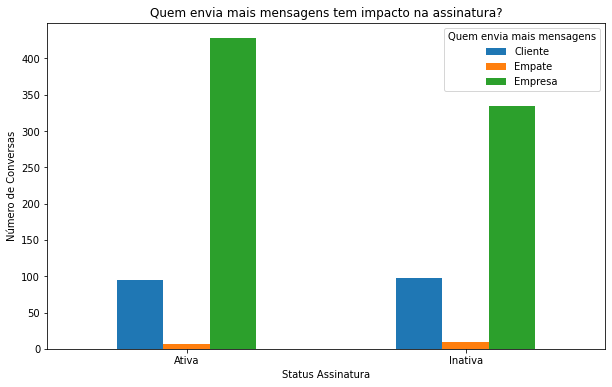

In [365]:
df_aux.groupby('Status Assinatura')['Quem envia mais mensagens'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Conversas', title='Quem envia mais mensagens tem impacto na assinatura?', figsize=(10,6))

In [323]:
df_regr['Mensagens Inbound'].describe()

count     681.000000
mean       88.295154
std       137.320426
min         0.000000
25%        17.000000
50%        47.000000
75%       113.000000
max      1436.000000
Name: Mensagens Inbound, dtype: float64

In [336]:
bins = [0, 10, 20, 50, 100, 150, 200, np.inf]
names = ['<10', '10-19', '20-49', '50-99', '100-149', '150-199', '200+']

df_aux['Mensagens Inbound Range'] = pd.cut(df_aux['Mensagens Inbound'], bins, labels=names)

df_aux['Mensagens Outbound Range'] = pd.cut(df_aux['Mensagens Outbound'], bins, labels=names)

C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\2941231498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Mensagens Inbound Range'] = pd.cut(df_aux['Mensagens Inbound'], bins, labels=names)
C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\2941231498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Mensagens Outbound Range'] = pd.cut(df_aux['Mensagens Outbound'], bins, labels=names)


<AxesSubplot:title={'center':'Impacto do Número de Mensagens Enviadas pela Empresa na Assinatura do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Mensagens'>

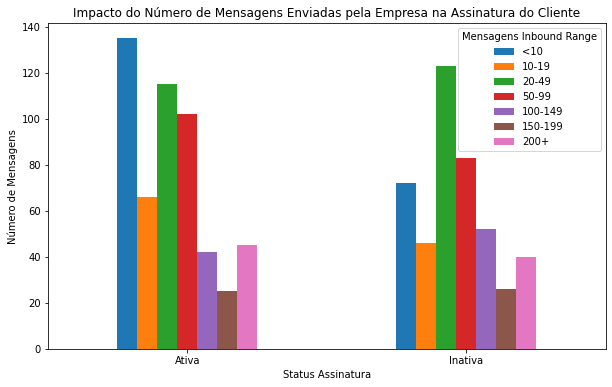

In [368]:
df_aux.groupby('Status Assinatura')['Mensagens Inbound Range'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Mensagens', title='Impacto do Número de Mensagens Enviadas pela Empresa na Assinatura do Cliente', figsize=(10,6))

<AxesSubplot:title={'center':'Impacto do Número de Mensagens Enviadas pelo Cliente na Assinatura do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Mensagens'>

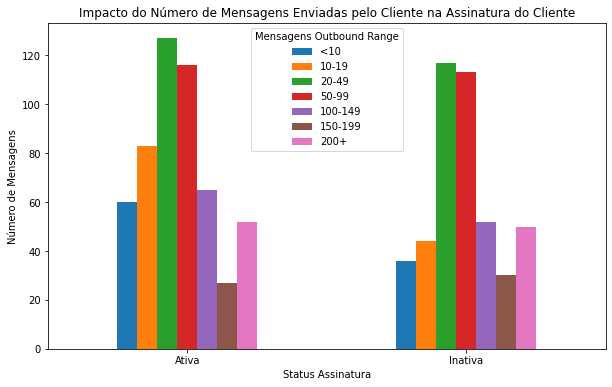

In [369]:
df_aux.groupby('Status Assinatura')['Mensagens Outbound Range'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Mensagens', title='Impacto do Número de Mensagens Enviadas pelo Cliente na Assinatura do Cliente', figsize=(10,6))

In [344]:
df_regr['Ligações Inbound'].describe()

count    681.000000
mean       0.720999
std        6.316061
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       80.000000
Name: Ligações Inbound, dtype: float64

<AxesSubplot:title={'center':' Impacto do Número de Ligações da Empresa no Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Mensagens'>

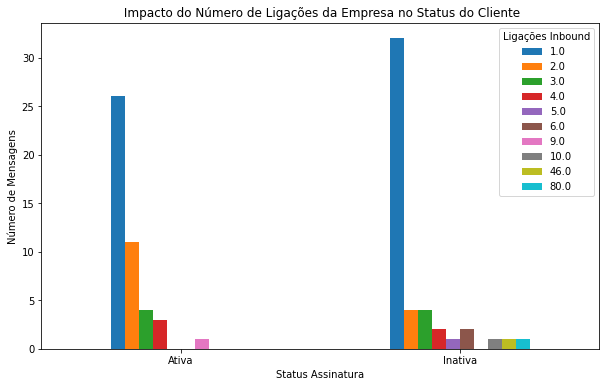

In [370]:
df_aux.groupby('Status Assinatura')['Ligações Inbound'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Mensagens', title=' Impacto do Número de Ligações da Empresa no Status do Cliente', figsize=(10,6))

<AxesSubplot:title={'center':'Impacto do Número de Ligações do Usuário no Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

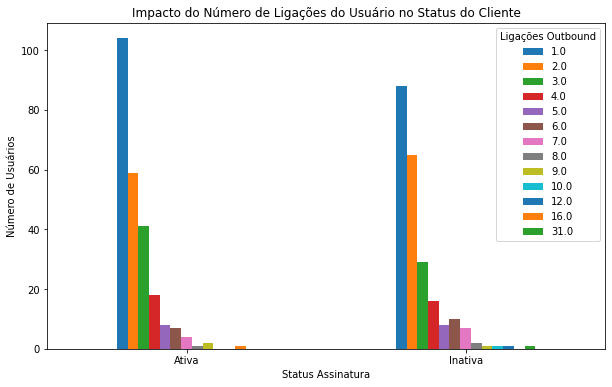

In [371]:
df_aux.groupby('Status Assinatura')['Ligações Outbound'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Impacto do Número de Ligações do Usuário no Status do Cliente', figsize=(10,6))

In [349]:
def retornaMensagensMais(x,y):
    if x>y:
        return 'Cliente'
    elif y>x:
        return 'Empresa'
    return 'Empate'



df_aux['Quem liga mais'] = df.apply(lambda row: retornaMensagensMais(row['Ligações Inbound'], row['Ligações Outbound']), axis=1)

df_aux['Quem liga mais']

C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\4072466146.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Quem liga mais'] = df.apply(lambda row: retornaMensagensMais(row['Ligações Inbound'], row['Ligações Outbound']), axis=1)


1193     Empate
1190     Empate
1189     Empate
1188     Empate
1187     Empate
         ...   
38       Empate
39       Empate
68       Empate
28       Empate
24      Empresa
Name: Quem liga mais, Length: 972, dtype: object

<AxesSubplot:title={'center':'Impacto de Quem Faz Mais Ligações no Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

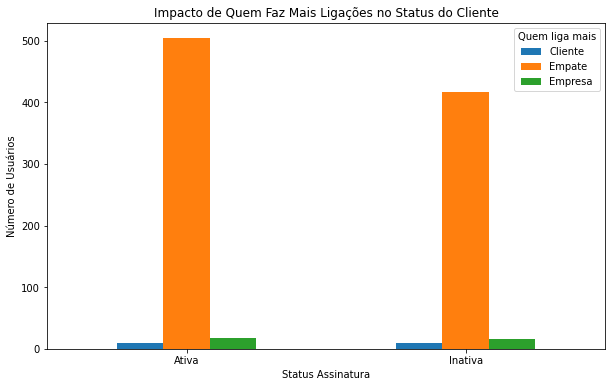

In [372]:
df_aux.groupby('Status Assinatura')['Quem liga mais'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Impacto de Quem Faz Mais Ligações no Status do Cliente', figsize=(10,6))

In [352]:
df_aux['Qde Atendimento Médico'].describe()

count    208.000000
mean       1.692308
std        1.516906
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       11.000000
Name: Qde Atendimento Médico, dtype: float64

<AxesSubplot:title={'center':'Impacto do Número de Atendimentos Médicos no Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

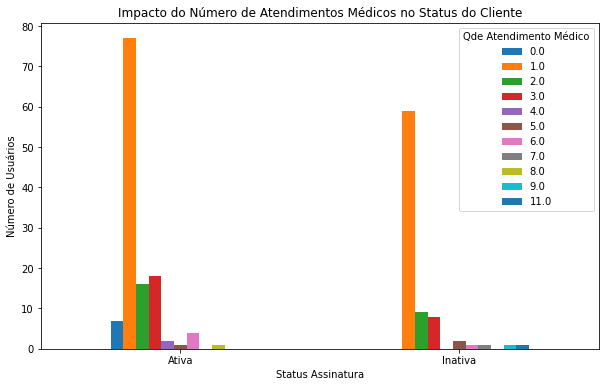

In [373]:
df_aux.groupby('Status Assinatura')['Qde Atendimento Médico'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Impacto do Número de Atendimentos Médicos no Status do Cliente', figsize=(10,6))

<AxesSubplot:title={'center':'Faltas de Atendimento Médico X Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

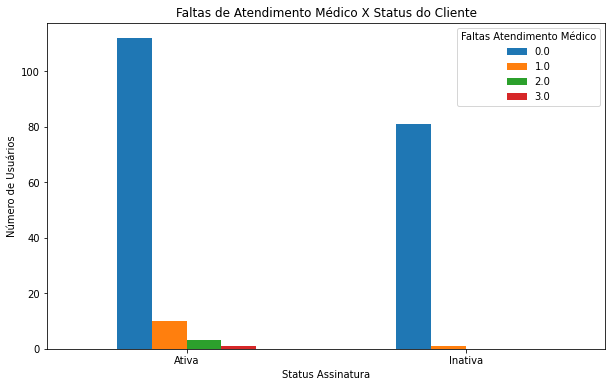

In [355]:
df_aux.groupby('Status Assinatura')['Faltas Atendimento Médico'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Faltas de Atendimento Médico X Status do Cliente', figsize=(10,6))

In [362]:
df_aux['Qde Psicoterapia'].describe()

count    426.000000
mean      11.495305
std       11.544950
min        1.000000
25%        3.000000
50%        8.000000
75%       17.000000
max       64.000000
Name: Qde Psicoterapia, dtype: float64

In [360]:
bins = [0, 10, 20, 30, 40, 50, np.inf]
names = ['<10', '10-19', '20-29', '30-39', '40-49', '50+']

df_aux['Qde Psicoterapia Range'] = pd.cut(df_aux['Qde Psicoterapia'], bins, labels=names)

C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\3334266953.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Qde Psicoterapia Range'] = pd.cut(df_aux['Qde Psicoterapia'], bins, labels=names)
C:\Users\jalfr\AppData\Local\Temp\ipykernel_17796\3334266953.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux['Qde Psicoterapia Range'] = pd.cut(df_aux['Qde Psicoterapia'], bins, labels=names)


<AxesSubplot:title={'center':'Atendimentos Psicoterapia X Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

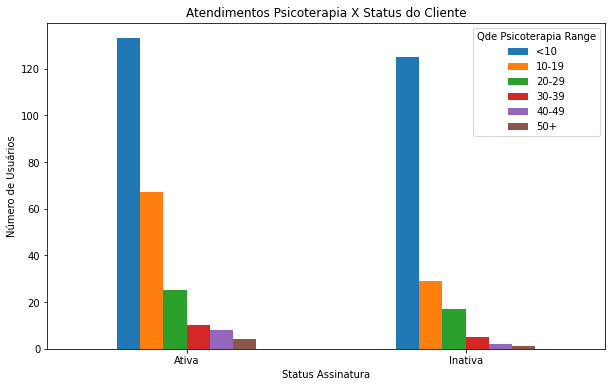

In [361]:
df_aux.groupby('Status Assinatura')['Qde Psicoterapia Range'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Atendimentos Psicoterapia X Status do Cliente', figsize=(10,6))

In [363]:
df_aux['Faltas Psicoterapia'].describe()

count    170.000000
mean       2.452941
std        2.089879
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: Faltas Psicoterapia, dtype: float64

<AxesSubplot:title={'center':'Faltas Psicoterapia X Status do Cliente'}, xlabel='Status Assinatura', ylabel='Número de Usuários'>

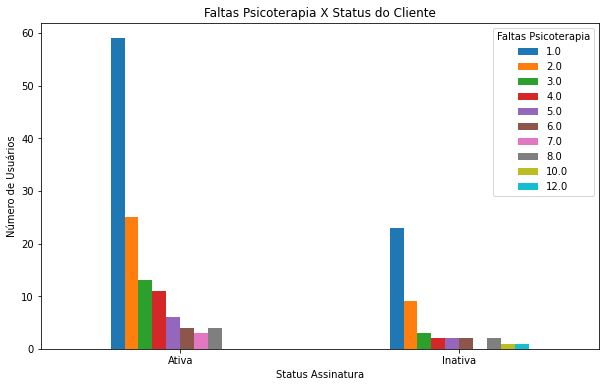

In [364]:
df_aux.groupby('Status Assinatura')['Faltas Psicoterapia'].value_counts().unstack().plot(kind='bar', rot=0, ylabel='Número de Usuários', title='Faltas Psicoterapia X Status do Cliente', figsize=(10,6))